# XGBoost model

In [49]:
import pandas as pd
import numpy as np
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

import modify_dataset as md

In [50]:
#Common error function to minimize: Root Mean Square Percentage Error
#We will have to integrate our loss function with xgboost

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe


In [51]:
df = pd.read_csv("dataset/enriched_train.csv")

In [52]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['D_Day_of_week'] = df['Date'].dt.dayofweek

In [53]:
df = df.drop(['NumberOfCustomers','IsOpen','Date'], axis=1)
#df = df.drop(['Region','Events'], axis=1)
# I could leave events

In [54]:
#for now let's drop unusable categorical vars
df = df.drop(['StoreType','AssortmentType','Events'], axis=1)

In [55]:
df.head().T

,0,1,2,3,4
StoreID,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
IsHoliday,0.000000,0.000000,0.000000,0.000000,0.000000
HasPromotions,1.000000,1.000000,1.000000,0.000000,0.000000
NearestCompetitor,326.000000,326.000000,326.000000,326.000000,326.000000
Region,7.000000,7.000000,7.000000,7.000000,7.000000
NumberOfSales,7109.000000,8041.000000,7890.000000,6005.000000,7675.446488
Region_AreaKM2,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000
Region_GDP,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000
Region_PopulationK,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000
CloudCover,6.000000,6.000000,5.000000,7.000000,8.000000


In [56]:
df.shape

(523000, 47)

In [57]:
train = md.get_fake_train5(df)

In [58]:
train.shape

(477311, 47)

In [59]:
test = md.get_fake_test5(df)
test.shape

(45689, 47)

In [60]:
#print("Load the training, test and store data using pandas")
#train = pd.read_csv("train.csv",low_memory=False)
#test = pd.read_csv("test.csv")
#store = pd.read_csv("store.csv")

### Selecting predictive features 

In [61]:
features = list(train.columns.values)
features.remove('NumberOfSales')
features.remove('StoreID')
features.remove('Region')
features.remove('Region_GDP')
features.remove('Max_Dew_PointC')
features.remove('Min_Dew_PointC')
features.remove('Max_Wind_SpeedKm_h')
features.remove('Max_VisibilityKm')
features.remove('Min_Sea_Level_PressurehPa')
print("features")

print(features)

features
['IsHoliday', 'HasPromotions', 'NearestCompetitor', 'Region_AreaKM2', 'Region_PopulationK', 'CloudCover', 'Max_Humidity', 'Max_Sea_Level_PressurehPa', 'Max_TemperatureC', 'Mean_Dew_PointC', 'Mean_Humidity', 'Mean_Sea_Level_PressurehPa', 'Mean_TemperatureC', 'Mean_VisibilityKm', 'Mean_Wind_SpeedKm_h', 'Min_Humidity', 'Min_TemperatureC', 'Min_VisibilitykM', 'Precipitationmm', 'WindDirDegrees', 'D_Day', 'D_DayOfYear', 'D_Month', 'D_Year', 't-14', 't-7', 't-1', 't-2', 't-9', 't-8', 't-6', 't-15', 't-21', 't-13', 't-20', 'MeanStoreSales', 'MeanRegionSales', 'D_Day_of_week']


In [62]:
params = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 8,
          "subsample": 1.0,
          "colsample_bytree": 0.3,
          "silent": 1,
          "nthread":-1
          }
num_trees = 100 #400

In [63]:
#split in train and test (not real test which is called test and is the fake test provided by md)
X_train, X_test = train_test_split(train, test_size=0.05)
#X_train, X_test = train.head(len(train) - val_size), train.tail(val_size)

In [64]:
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["NumberOfSales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#dtest = xgb.DMatrix(test[features])

In [65]:
X_train.shape

(453445, 47)

In [66]:
X_test.shape

(23866, 47)

In [67]:
watchlist = [(dvalid, 'test'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, feval=rmspe_xg, verbose_eval=True)

[0]	test-rmse:6.33402	train-rmse:6.33477	test-rmspe:0.998329	train-rmspe:0.998298
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 20 rounds.
[1]	test-rmse:5.06871	train-rmse:5.06959	test-rmspe:0.993569	train-rmspe:0.993542
[2]	test-rmse:4.0564	train-rmse:4.05745	test-rmspe:0.982102	train-rmspe:0.982088
[3]	test-rmse:3.24696	train-rmse:3.24792	test-rmspe:0.959852	train-rmspe:0.959861
[4]	test-rmse:2.5996	train-rmse:2.60071	test-rmspe:0.923537	train-rmspe:0.923597
[5]	test-rmse:2.08176	train-rmse:2.0831	test-rmspe:0.872148	train-rmspe:0.872319
[6]	test-rmse:1.6681	train-rmse:1.66948	test-rmspe:0.807175	train-rmspe:0.807525
[7]	test-rmse:1.3375	train-rmse:1.33906	test-rmspe:0.732268	train-rmspe:0.732944
[8]	test-rmse:1.07388	train-rmse:1.07552	test-rmspe:0.652099	train-rmspe:0.653252
[9]	test-rmse:0.863344	train-rmse:0.865118	test-rmspe:0.571363	train-rmspe:0.573279
[10]	test-rmse:0.69595	train-rmse:0.

### Validating

In [68]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

Validating
error 0.10908266461737255


RMSE

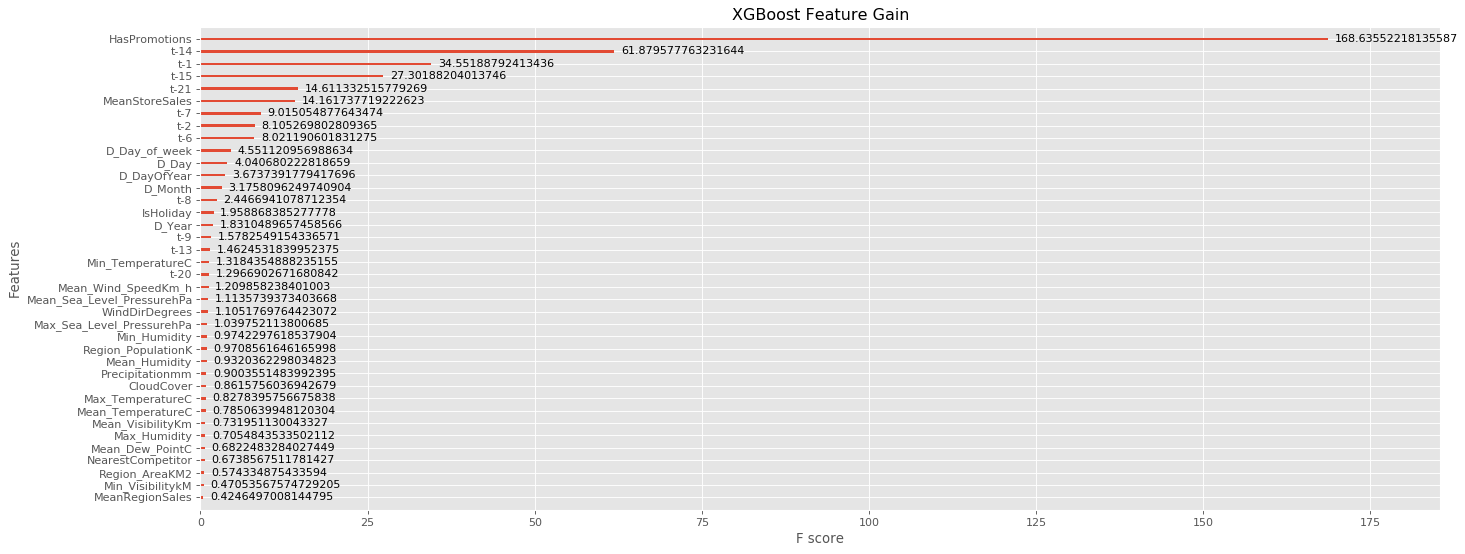

In [69]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="gain")
plt.title("XGBoost Feature Gain")
plt.show()

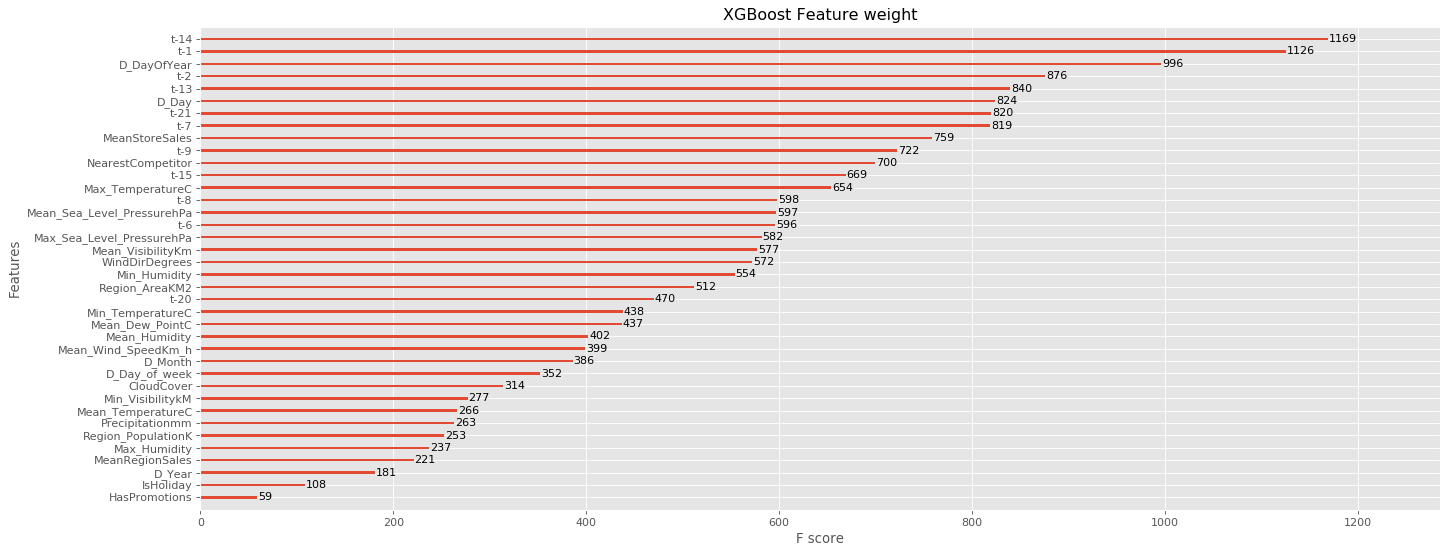

In [70]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="weight")
plt.title("XGBoost Feature weight")
plt.show()

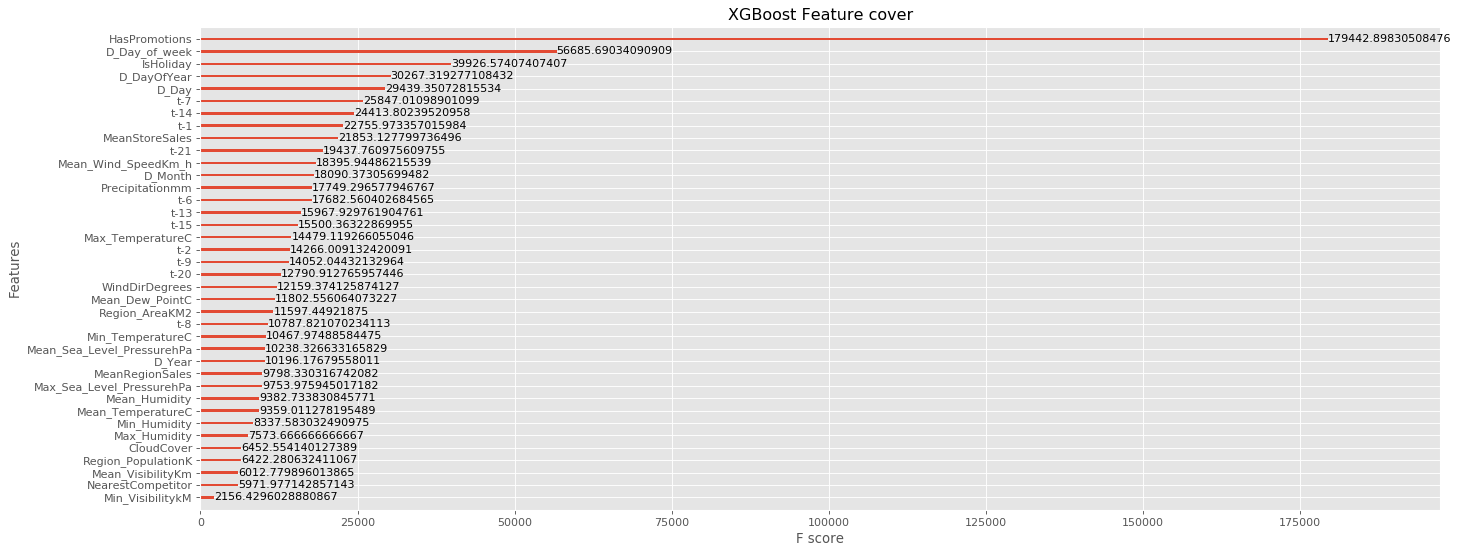

In [71]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="cover")
plt.title("XGBoost Feature cover")
plt.show()

### Predict on fake test set

In [72]:
train_probs = gbm.predict(xgb.DMatrix(test[features]))

In [73]:
test['_NumberOfSales'] = np.exp(gbm.predict(xgb.DMatrix(test[features])))-1

C:\Users\Mirko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## BIP Error

In [74]:
from BIP_error import get_BIP_error
error1 = get_BIP_error(test)

Number of regions identified: 11
BIP total error: 0.035552105720639535


In [75]:
diff=test['NumberOfSales']-test['_NumberOfSales']

In [76]:
diff.head(15).T

374      652.841996
375       64.412309
376    12820.952148
377     4092.291016
378     4071.205078
379     1195.629883
380     3646.757324
381      297.708496
382      141.074906
383     -548.175293
384     -390.903320
385     -450.113281
386      275.673828
387      724.926270
388      160.796875
dtype: float64

In [77]:
diff.mean()

116.62360804614353

In [78]:
train_probs.shape

(45689,)

In [79]:
#test['predicted'] = pd.Series([train_probs], index=test.index)
#test['predicted']=train_probs

In [80]:
test.head(10).T

,374,375,376,377,378,379,380,381,382,383
StoreID,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
IsHoliday,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HasPromotions,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
NearestCompetitor,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
Region,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
NumberOfSales,7675.446488,7675.446488,22672.000000,14802.000000,12014.000000,10630.000000,11578.000000,8361.000000,7675.446488,7480.000000
Region_AreaKM2,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000
Region_GDP,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000
Region_PopulationK,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000
CloudCover,0.000000,0.000000,8.000000,8.000000,0.000000,0.000000,7.000000,6.000000,3.000000,6.000000


In [81]:
compare = test[['NumberOfSales','_NumberOfSales']]

### Saving TEST

In [82]:
test.to_csv('./dataset/XGB5_fake_test.csv', index=False)

In [ ]:
error = rmspe(test['_NumberOfSales'].values, test['NumberOfSales'].values)
print('error', error)

In [ ]:
compare[1000:1100]

In [ ]:
#REAL
start = 500
end = 600
import matplotlib.pyplot as plt

y = compare.iloc[start:end,0].values
x_coordinate = [ 1 * i for i in range(len(y)) ]
plt.plot(x_coordinate,y)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

yhat = compare.iloc[start:end:1].values
x_coordinate = [ 1 * i for i in range(len(yhat)) ]
plt.plot(x_coordinate,yhat)
plt.legend(['Real', 'Predicted'], loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
#import matplotlib as mpl

#mpl.style.use("default")


plt.plot(x_coordinate,y)
plt.plot(x_coordinate,yhat)
plt.legend(['Predicted', 'Real'], loc='upper left')
plt.show()

In [ ]:
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

In [ ]:
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("xgboost_kscript_submission.csv", index=False)

In [ ]:
Y = df.iloc[:, 3]

In [ ]:
Y